In [28]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels
from utility.types import StochasticModelEnum
from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
    compute_current_price,
    compute_current_variance,
)
from data_provider.data_provider import DataProvider
from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter
from filters.ssm import HestonDSSM

In [29]:

# df = DataProvider.get_stochastic_fake_data(total_points=1000)
# df.head()
df = pd.read_excel(
    "../data/APPLE.xlsx", sheet_name="Feuil1", names=["date", "prices"], skiprows=0
).iloc[-1000:]
df["returns"] = df.prices.pct_change().fillna(0)
df["variance"] = df.returns.rolling(100).var()
df["vol"] = df.returns.rolling(100).std().apply(lambda x: x * np.sqrt(252*60*6.5))
df["volvol"] = df.vol.rolling(100).std()
df = df.dropna().reset_index(drop=True)
df.head()

,date,prices,returns,variance,vol,volvol
0,2023-12-29 11:22:00,193.70,-0.000258,2.745644e-08,0.051946,0.007244
1,2023-12-29 11:23:00,193.74,0.000207,2.788928e-08,0.052354,0.007270
2,2023-12-29 11:24:00,193.76,0.000103,2.799475e-08,0.052453,0.007294
3,2023-12-29 11:25:00,193.75,-0.000052,2.758372e-08,0.052067,0.007315
4,2023-12-29 11:26:00,193.75,0.000000,2.758372e-08,0.052067,0.007333


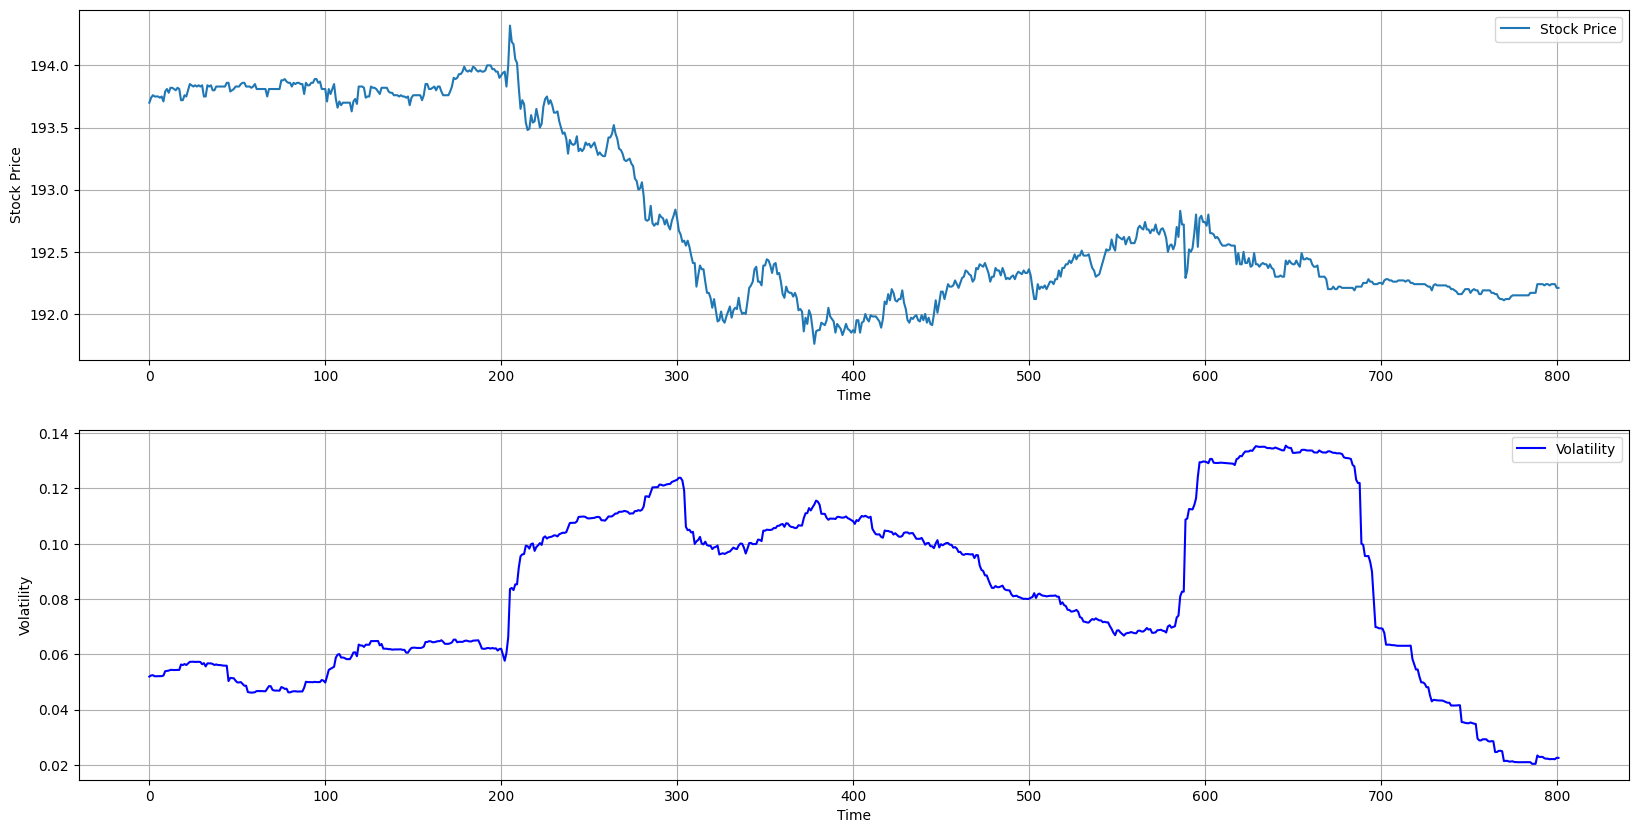

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.prices, label="Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.vol, color="blue", label="Volatility")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [31]:
Z = df[["prices", "variance"]].to_numpy()


ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 5]]),
    R=np.array([[20, 0.0], [0.0, 20]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, z=Z, x0=Z[0])


UKF:   8%|▊         | 67/801 [00:00<00:01, 662.81it/s]

UKF: 100%|██████████| 801/801 [00:01<00:00, 652.52it/s]


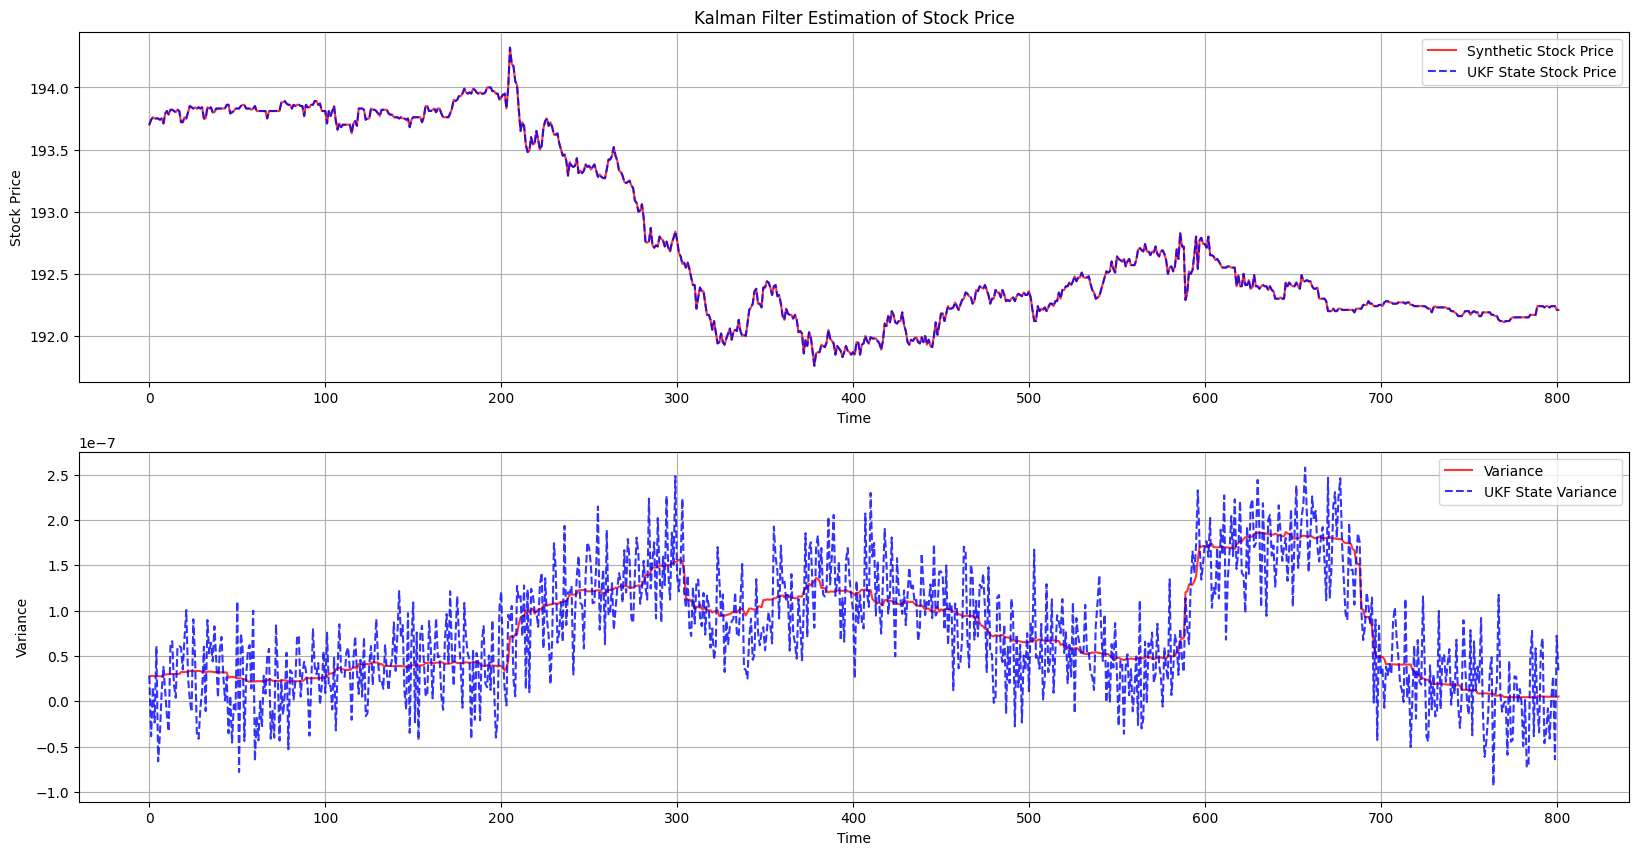

In [32]:

N = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.index[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.index[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.index[-N:], df.variance[-N:], color="red", label="Variance", alpha=0.8
)
ax[1].plot(
    df.index[-N:],
    X_hat[-N:, -1],
    color="blue",
    label="UKF State Variance",
    alpha=0.8,
    linestyle="--",
)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Variance")
ax[1].legend()
ax[1].grid()

## Our SSM


In [33]:
from typing import List
from filters.ssm import DSSM

# order [kappa, theta, xi, rho, mu, p, ]
LEARNABLE_PARAMS = [20, 0.0729, 0.01, -0.3, 0.3, 0.5]


hdssm = HestonDSSM(LEARNABLE_PARAMS)

## Heston SSM


In [34]:
ukf = UnscentedKalmanFilter(
    dim_x=2,
    dim_z=2,
    Q=np.array([[1.0, 0.0], [0.0, 1.0]]),
    R=np.array([[1.0, 0.0], [0.0, 1.0]]),
)

X_hat, _, X_hat_estim = ukf.fit_predict(
    state_function=hdssm.f,
    observation_function=hdssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["variance", "prices"]].dropna().to_numpy()[0],
    verbose=True,
    keep_state_estimates=True,
)

UKF:   6%|▌         | 50/801 [00:00<00:03, 243.04it/s]

P=[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
P=[[-4.57572049e+13 -6.49385413e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.49385413e-04  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 6.76443242e+06  6.76443506e+06  6.76443242e+06  6.76443242e+06
   6.76443242e+06  6.76443506e+06  6.76443242e+06  6.76442977e+06
   6.76443242e+06  6.76443242e+06  6.76443242e+06  6.76442977e+06
   6.76443242e+06]
 [-6.55121993e+08 -6.55122250e+08 -6

UKF:  14%|█▍        | 116/801 [00:00<00:02, 299.63it/s]

P=[[ 3.61998526e+08 -4.18007276e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.18007276e-04  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.67139967e+03  5.40101490e+04  3.67139967e+03  3.67139967e+03
   3.67139967e+03  3.67404543e+03  3.67139967e+03 -4.66673496e+04
   3.67139967e+03  3.67139967e+03  3.67139967e+03  3.66875392e+03
   3.67139967e+03]
 [-7.29547811e+08 -1.07504627e+10 -7.36402048e+08 -7.29547811e+08
  -7.29547811e+08 -7.29547811e+08 -7.29547808e+08  9.29680424e+09
  -7.22693573e+08 -7.29547811e+08

UKF:  23%|██▎       | 185/801 [00:00<00:01, 322.48it/s]

P=[[ 3.61999932e+08 -6.80420234e-11  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.80420234e-11  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.68721234e+03  5.40260594e+04  3.68721234e+03  3.68721234e+03
   3.68721234e+03  3.68985809e+03  3.68721234e+03 -4.66516347e+04
   3.68721234e+03  3.68721234e+03  3.68721234e+03  3.68456658e+03
   3.68721234e+03]
 [ 1.01651737e+09  1.49223970e+10  1.00963553e+09  1.01651737e+09
   1.01651737e+09  1.01651737e+09  1.01651737e+09 -1.28984626e+10
   1.02339920e+09  1.01651737e+09

UKF:  31%|███▏      | 251/801 [00:00<00:01, 299.70it/s]

P=[[ 3.62000150e+08 -5.78311982e-11  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.78311982e-11  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.68235326e+03  5.40212155e+04  3.68235326e+03  3.68235326e+03
   3.68235326e+03  3.68499901e+03  3.68235326e+03 -4.66565089e+04
   3.68235326e+03  3.68235326e+03  3.68235326e+03  3.67970751e+03
   3.68235326e+03]
 [ 1.11287328e+09  1.63558193e+10  1.10599985e+09  1.11287328e+09
   1.11287328e+09  1.11287328e+09  1.11287328e+09 -1.41394559e+10
   1.11974672e+09  1.11287328e+09

UKF:  35%|███▌      | 282/801 [00:00<00:01, 280.59it/s]

y_sigmas=[[ 3.67244706e+03  5.40112643e+04  3.67244706e+03  3.67244706e+03
   3.67244706e+03  3.67509281e+03  3.67244706e+03 -4.66663702e+04
   3.67244706e+03  3.67244706e+03  3.67244706e+03  3.66980131e+03
   3.67244706e+03]
 [ 1.07362194e+09  1.58405388e+10  1.06677982e+09  1.07362194e+09
   1.07362194e+09  1.07362194e+09  1.07362194e+09 -1.37132345e+10
   1.08046406e+09  1.07362194e+09  1.07362194e+09  1.07362194e+09
   1.07362194e+09]]
x= [   3672.44706029 -587116.92037964] 
K= [[ 1.00000004e+00 -1.49330014e-13]
 [-5.29257100e-04  1.80296277e-09]] 
z= [1.93250000e+02 1.25007927e-07] 
y= [ 3.67244706e+03 -1.42317974e+12]
P=[[-3.61999140e+14 -5.60690453e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.60690438e+02  8.59391792e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+

UKF:  42%|████▏     | 337/801 [00:01<00:01, 244.61it/s]

P=[[3.61999710e+08 9.88784055e-12 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.88784055e-12 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[ 3.65125860e+03  5.39900902e+04  3.65125860e+03  3.65125860e+03
   3.65125860e+03  3.65390435e+03  3.65125860e+03 -4.66875730e+04
   3.65125860e+03  3.65125860e+03  3.65125860e+03  3.64861285e+03
   3.65125860e+03]
 [ 1.10240392e+09  1.63714335e+10  1.09561148e+09  1.10240392e+09
   1.10240392e+09  1.10240392e+09  1.10240392e+09 -1.41961692e+10
   1.10919635e+09  1.10240392e+09  1.10240392e+09  1.10240392e+09
   

UKF:  48%|████▊     | 386/801 [00:01<00:01, 217.31it/s]

y_sigmas=[[ 3.66046251e+03  5.39990988e+04  3.66046251e+03  3.66046251e+03
   3.66046251e+03  3.66310826e+03  3.66046251e+03 -4.66781738e+04
   3.66046251e+03  3.66046251e+03  3.66046251e+03  3.65781675e+03
   3.66046251e+03]
 [ 5.11321242e+09  7.48625067e+10  5.10629266e+09  5.11321242e+09
   5.11321242e+09  5.11321242e+09  5.11321242e+09 -6.43300711e+10
   5.12013217e+09  5.11321242e+09  5.11321242e+09  5.11321242e+09
   5.11321241e+09]]
x= [    3660.46250516 -2764821.02252197] 
K= [[ 1.00000000e+00 -2.89327860e-15]
 [-1.07035349e-05  7.74181155e-12]] 
z= [1.92410000e+02 1.13563916e-07] 
y= [3.6604625e+03 2.1863023e+13]
P=[[-3.61996537e+14 -1.05757909e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.05757918e+01  2.02863515e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00

UKF:  55%|█████▍    | 440/801 [00:01<00:01, 235.62it/s]

P=[[3.61999417e+08 7.25995933e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.25995933e+00 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[ 3.64662423e+03  5.39854355e+04  3.64662423e+03  3.64662423e+03
   3.64662423e+03  3.64926998e+03  3.64662423e+03 -4.66921870e+04
   3.64662423e+03  3.64662423e+03  3.64662423e+03  3.64397848e+03
   3.64662423e+03]
 [ 5.01800114e+09  7.44371836e+10  5.01119618e+09  5.01800114e+09
   5.01800114e+09  5.01800114e+09  5.01800114e+09 -6.44507360e+10
   5.02480610e+09  5.01800114e+09  5.01800114e+09  5.01800114e+09
   

UKF:  68%|██████▊   | 542/801 [00:02<00:00, 301.12it/s]

P=[[3.61999620e+08 7.28336982e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.28336982e+00 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[ 3.65369193e+03  5.39925173e+04  3.65369193e+03  3.65369193e+03
   3.65369193e+03  3.65633768e+03  3.65369193e+03 -4.66851334e+04
   3.65369193e+03  3.65369193e+03  3.65369193e+03  3.65104618e+03
   3.65369193e+03]
 [ 5.00644089e+09  7.43656505e+10  4.99965167e+09  5.00644089e+09
   5.00644089e+09  5.00644089e+09  5.00644089e+09 -6.45180239e+10
   5.01323010e+09  5.00644089e+09  5.00644089e+09  5.00644089e+09
   

UKF:  72%|███████▏  | 573/801 [00:02<00:00, 258.95it/s]

P=[[-3.61999682e+14 -1.38789170e+08  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.38789170e+08 -1.99999797e+12  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
P=[[3.61999954e+08 7.28337319e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.28337319e+00 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000

UKF:  75%|███████▌  | 601/801 [00:02<00:00, 216.92it/s]

P=[[ 3.62000664e+08 -7.30678883e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.30678883e+00  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.66016962e+03  5.39990676e+04  3.66016962e+03  3.66016962e+03
   3.66016962e+03  3.66281537e+03  3.66016962e+03 -4.66787283e+04
   3.66016962e+03  3.66016962e+03  3.66016962e+03  3.65752387e+03
   3.66016962e+03]
 [ 4.99169860e+09  7.40503015e+10  4.98490057e+09  4.99169860e+09
   4.99169860e+09  4.99169860e+09  4.99169860e+09 -6.42443892e+10
   4.99849662e+09  4.99169860e+09

UKF:  78%|███████▊  | 625/801 [00:02<00:00, 202.55it/s]

y_sigmas=[[ 3.65467716e+03  5.39935875e+04  3.65467716e+03  3.65467716e+03
   3.65467716e+03  3.65732291e+03  3.65467716e+03 -4.66842332e+04
   3.65467716e+03  3.65467716e+03  3.65467716e+03  3.65203141e+03
   3.65467716e+03]
 [ 5.00434742e+09  7.39784903e+10  4.99751452e+09  5.00434742e+09
   5.00434742e+09  5.00434742e+09  5.00434743e+09 -6.39678287e+10
   5.01118033e+09  5.00434742e+09  5.00434742e+09  5.00434742e+09
   5.00434742e+09]]
x= [    3654.67716259 -2740349.76556396] 
K= [[ 5.32687608e-13  7.29854511e-07]
 [-3.91165052e-18 -5.35949351e-12]] 
z= [1.92410000e+02 1.80910208e-07] 
y= [3.65467716e+03 1.45484809e+11]
P=[[-3.62010989e+14  2.65833458e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.65833458e+09  1.98047922e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+

UKF:  81%|████████  | 647/801 [00:02<00:01, 148.24it/s]

y_sigmas=[[ 3.63154821e+03  5.39704500e+04  3.63154821e+03  3.63154821e+03
   3.63154821e+03  3.63419396e+03  3.63154821e+03 -4.67073536e+04
   3.63154821e+03  3.63154821e+03  3.63154821e+03  3.62890246e+03
   3.63154821e+03]
 [ 4.98085775e+09  7.39378737e+10  4.97405188e+09  4.98085775e+09
   4.98085775e+09  4.98085775e+09  4.98085775e+09 -6.39095370e+10
   4.98766362e+09  4.98085775e+09  4.98085775e+09  4.98085775e+09
   4.98085774e+09]]
x= [    3631.54820901 -2738321.95892334] 
K= [[ 1.00000009e+00 -6.75678994e-14]
 [-2.19963673e-04  1.60651205e-10]] 
z= [1.92310000e+02 1.82805937e-07] 
y= [3.63154821e+03 4.76363808e+12]
P=[[-3.62000356e+14  3.84328727e+05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.84328727e+05  2.58443150e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+

UKF:  86%|████████▌ | 687/801 [00:03<00:00, 144.44it/s]

P=[[ 3.61998644e+08 -3.82494036e-12  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.82494036e-12  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.64598319e+03  5.39847407e+04  3.64598319e+03  3.64598319e+03
   3.64598319e+03  3.64862894e+03  3.64598319e+03 -4.66927743e+04
   3.64598319e+03  3.64598319e+03  3.64598319e+03  3.64333744e+03
   3.64598319e+03]
 [ 4.96749922e+09  7.38800753e+10  4.96071782e+09  4.96749922e+09
   4.96749922e+09  4.96749922e+09  4.96749922e+09 -6.40832014e+10
   4.97428061e+09  4.96749922e+09

UKF:  92%|█████████▏| 733/801 [00:03<00:00, 172.59it/s]

P=[[3.61997652e+08 3.84566229e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.84566229e-01 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[ 3.64200181e+03  5.39806904e+04  3.64200181e+03  3.64200181e+03
   3.64200181e+03  3.64464757e+03  3.64200181e+03 -4.66966867e+04
   3.64200181e+03  3.64200181e+03  3.64200181e+03  3.63935606e+03
   3.64200181e+03]
 [ 4.95626510e+09  7.37694178e+10  4.94948879e+09  4.95626510e+09
   4.95626510e+09  4.95626510e+09  4.95626510e+09 -6.39855415e+10
   4.96304141e+09  4.95626510e+09  4.95626510e+09  4.95626510e+09
   

UKF:  97%|█████████▋| 774/801 [00:03<00:00, 183.02it/s]

P=[[ 3.62000138e+08 -1.92336647e-10  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.92336647e-10  2.00000000e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
y_sigmas=[[ 3.67217248e+03  5.40110338e+04  3.67217248e+03  3.67217248e+03
   3.67217248e+03  3.67481823e+03  3.67217248e+03 -4.66666889e+04
   3.67217248e+03  3.67217248e+03  3.67217248e+03  3.66952673e+03
   3.67217248e+03]
 [ 5.02211059e+09  7.39772775e+10  5.01525326e+09  5.02211059e+09
   5.02211059e+09  5.02211059e+09  5.02211059e+09 -6.39639747e+10
   5.02896791e+09  5.02211059e+09

UKF: 100%|██████████| 801/801 [00:03<00:00, 218.93it/s]

P=[[3.61999717e+08 3.84567328e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.84567328e-01 2.00000000e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
y_sigmas=[[ 3.66311742e+03  5.40019495e+04  3.66311742e+03  3.66311742e+03
   3.66311742e+03  3.66576317e+03  3.66311742e+03 -4.66757147e+04
   3.66311742e+03  3.66311742e+03  3.66311742e+03  3.66047167e+03
   3.66311742e+03]
 [ 4.98457880e+09  7.38010404e+10  4.97776434e+09  4.98457880e+09
   4.98457880e+09  4.98457880e+09  4.98457880e+09 -6.39654005e+10
   4.99139325e+09  4.98457880e+09  4.98457880e+09  4.98457880e+09
   

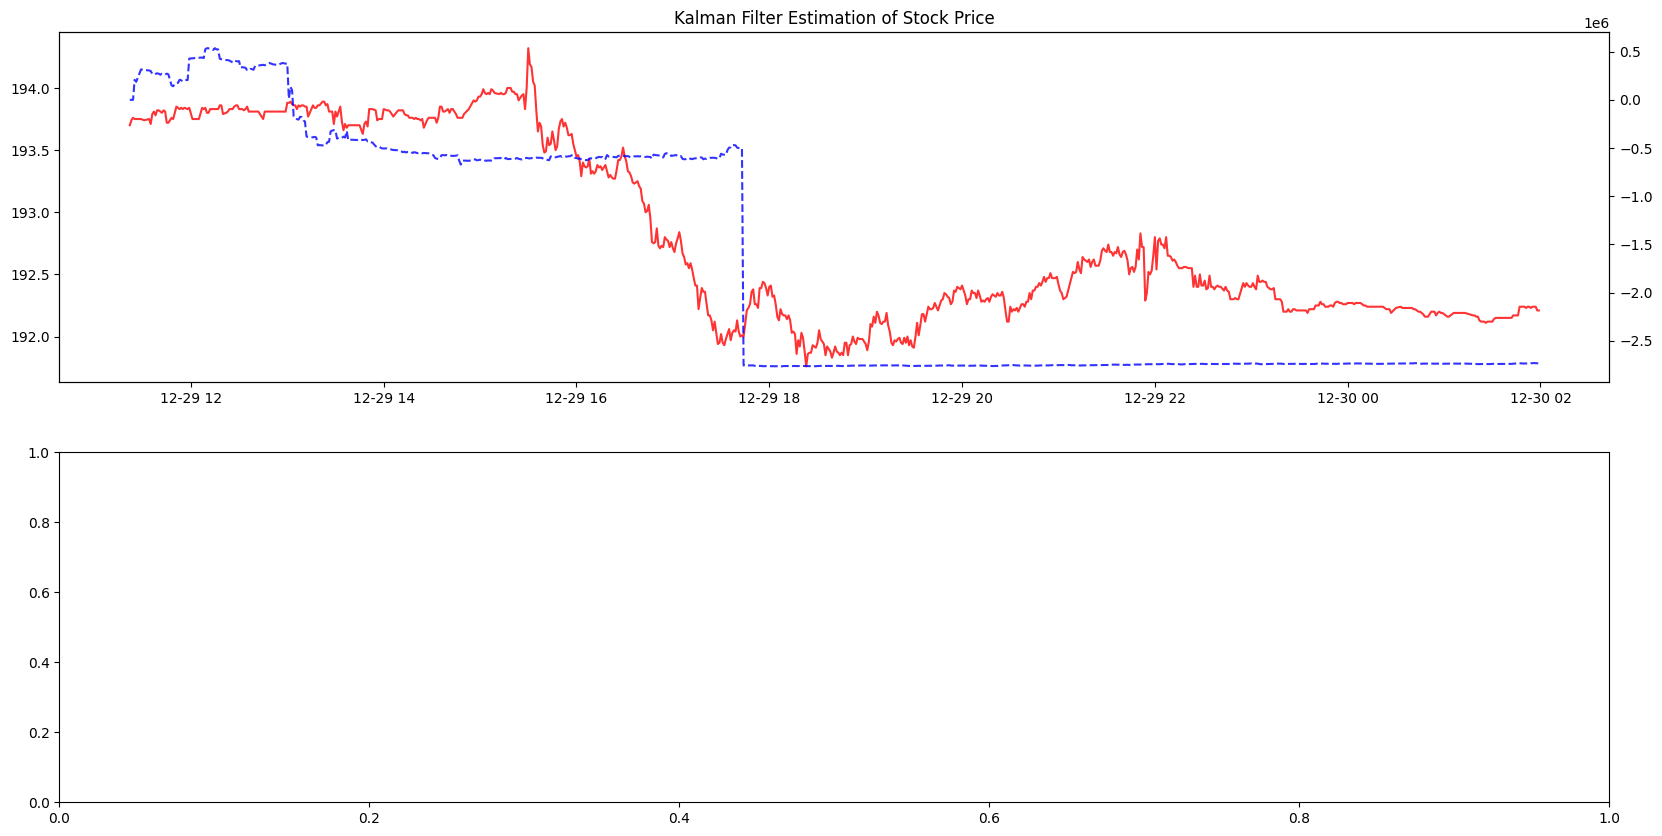

In [38]:
N = 1000
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.date[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
axl = ax[0].twinx()
axl.plot(
    df.date[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
# ax[0].plot(
#     df.Date[-N:],
#     X_hat_estim[-N:, 1],
#     color="green",
#     label="UKF State Stock Price estimated only",
#     alpha=0.8,
#     linestyle="--",
# )

# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Stock Price")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(
#     df.Date[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
# )

# ax[1].plot(
#     df.Date[-N:],
#     X_hat[-N:, 0],
#     color="blue",
#     label="UKF State Volatility",
#     alpha=0.8,
#     linestyle="--",
# )
# ax[1].plot(
#     df.Date[-N:],
#     X_hat_estim[-N:, 0],
#     color="green",
#     label="UKF State Volatility estimated only",
#     alpha=0.8,
#     linestyle="--",
# )


# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Volatility")
# ax[1].legend()
# ax[1].grid()

# Article SSM


In [39]:
# df["prices_t_1"] = df.prices.shift(1)
# Z = df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()

In [40]:
LEARNABLE_PARAMS = [4, 0.27, 0.99, -0.3, 0.3, 0.5]

dssm = DSSM(LEARNABLE_PARAMS)

In [42]:
df["prices_t_1"] = df.prices.shift(1)
df = df.dropna().reset_index(drop=True)

In [43]:
ukf = UnscentedKalmanFilter(
    dim_x=3,
    dim_z=3,
    Q=np.array([[10, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]),
    R=np.array([[5, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]),
)

X_hat, _, X_hat_estim = ukf.fit_predict(
    dssm.f,
    dssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()[0],
    verbose=False,
    keep_state_estimates=True,
)

UKF:   0%|          | 0/801 [00:00<?, ?it/s]


OverflowError: math range error

In [ ]:
N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].plot(
    df.t[-N:],
    X_hat_estim[-N:, 1],
    color="green",
    label="UKF State Stock Price estimated only",
    alpha=0.8,
    linestyle="--",
)

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)

ax[1].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Volatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].plot(
    df.t[-N:],
    X_hat_estim[-N:, 0],
    color="green",
    label="UKF State Volatility estimated only",
    alpha=0.8,
    linestyle="--",
)


ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()